<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/SMA_Crossover_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip  install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [2]:
# Download most recent 1-hour stock data (Max available: last 720 days)
df = yf.download("AAPL", period="720d", interval="1h")

# Print actual column names to check the structure
print("Original column names:", df.columns)

[*********************100%***********************]  1 of 1 completed

Original column names: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [3]:
# Fix Multi-Index Columns: Extract only the first level (Price Type)
df.columns = df.columns.get_level_values(0)  # Extract 'Close', 'High', 'Low', 'Open', 'Volume'

# Reset index to make "Datetime" a column
df = df.reset_index()


In [4]:
# Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-03-30 13:30:00+00:00  178.550003  179.610001  178.199997   
1     2022-03-30 14:30:00+00:00  178.908096  179.024994  177.468597   
2     2022-03-30 15:30:00+00:00  177.649994  178.179993  177.500000   
3     2022-03-30 16:30:00+00:00  177.770004  178.470001  177.660004   
4     2022-03-30 17:30:00+00:00  178.199997  179.350006  177.949997   

Price       Close    Volume  
0      178.904999  24564204  
1      177.649994  11397715  
2      177.761200   8532628  
3      178.199997   7854352  
4      178.009995  10279636  


In [5]:
# Reset index to make "Datetime" a column
df = df.reset_index()

# Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-03-30 13:30:00+00:00  178.550003  179.610001  178.199997   
1     2022-03-30 14:30:00+00:00  178.908096  179.024994  177.468597   
2     2022-03-30 15:30:00+00:00  177.649994  178.179993  177.500000   
3     2022-03-30 16:30:00+00:00  177.770004  178.470001  177.660004   
4     2022-03-30 17:30:00+00:00  178.199997  179.350006  177.949997   

Price       Close    Volume  
0      178.904999  24564204  
1      177.649994  11397715  
2      177.761200   8532628  
3      178.199997   7854352  
4      178.009995  10279636  


In [6]:
print(df.isnull().sum())  # Check for NaNs
df.dropna(inplace=True)  # Remove missing values

Price
Datetime    0
Open        0
High        0
Low         0
Close       0
Volume      0
dtype: int64


In [7]:
print(df.dtypes)  # Ensure Datetime is correctly formatted
df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert if necessary

Price
Datetime    datetime64[ns, UTC]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                    int64
dtype: object


In [84]:
# Calculate ATR (Average True Range) for Dynamic Stop-Loss
df['ATR'] = df['High'].rolling(14).max() - df['Low'].rolling(14).min()
df['ATR'] = df['ATR'].rolling(14).mean()
df.dropna(subset=['ATR'], inplace=True)  # Remove NaNs

# Set Stop-Loss as 1.2x ATR and Take-Profit as 3.5x ATR for better profit potential
df['Stop_Loss'] = df['Close'] - (2 * df['ATR'])  # Instead of 1.2x
df['Take_Profit'] = df['Close'] + (4.5 * df['ATR'])

# Calculate 14-period RSI for Entry Strategy
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df.dropna(subset=['RSI'], inplace=True)  # Remove NaNs

In [85]:
# Moving Averages for Signal Calculation
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()


In [86]:
# MACD Calculation
df['MACD_Line'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()

# Volume Calculation
df['Volume_Avg'] = df['Volume'].rolling(20).mean()

In [94]:
# Ensure ADX is Calculated Before Using It
df['ADX'] = abs(df['SMA_10'].diff(1) / df['SMA_50']).rolling(window=14).mean()
df.dropna(subset=['ADX'], inplace=True)  # Remove NaNs to avoid errors


In [95]:
print(df.columns)  # Check if 'ADX' is in the dataset
print(df[['ADX']].head())  # See first ADX values


Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'ATR',
       'Stop_Loss', 'Take_Profit', 'RSI', 'SMA_10', 'SMA_50', 'SMA_20',
       'MACD_Line', 'MACD_Signal', 'Volume_Avg', 'Buy_Signal', 'Sell_Signal',
       'Position_Size', 'Trailing_Stop', 'Exit_Signal', 'ADX'],
      dtype='object', name='Price')
Price       ADX
218    0.004884
219    0.004895
220    0.004683
221    0.004418
222    0.004367


In [118]:
# Updated Buy Signal Conditions
df['Buy_Signal'] = (
    (df['RSI'] < 49) &
    (df['SMA_10'] > df['SMA_50']) &
    (df['MACD_Line'] > df['MACD_Signal'] - 0.01) &
    (df['Volume'] > (0.6 * df['Volume_Avg']))
)


# Sell Signal Conditions
df['Sell_Signal'] = (
    (df['RSI'] > 70) |
    ((df['SMA_10'] < df['SMA_20']) & (df['SMA_20'] < df['SMA_50'])) |
    (df['MACD_Line'] < df['MACD_Signal']) |
    (df['Volume'] < df['Volume_Avg'])
)

In [119]:
# Risk 2% of portfolio per trade
initial_balance = 10000
risk_per_trade = 0.03 * initial_balance

# Adjust position size dynamically based on ATR
df['Position_Size'] = np.where(df['ATR'].notna(), risk_per_trade / df['ATR'], np.nan)
df.dropna(subset=['Position_Size'], inplace=True)  # Remove NaNs

# Implement Trailing Stop for Smarter Exits
df['Trailing_Stop'] = np.where(df['ATR'].notna(), df['Close'] - (1.5 * df['ATR']), np.nan)
df['Exit_Signal'] = df['Close'] < df['Trailing_Stop']
df.dropna(subset=['Trailing_Stop'], inplace=True)  # Remove NaNs

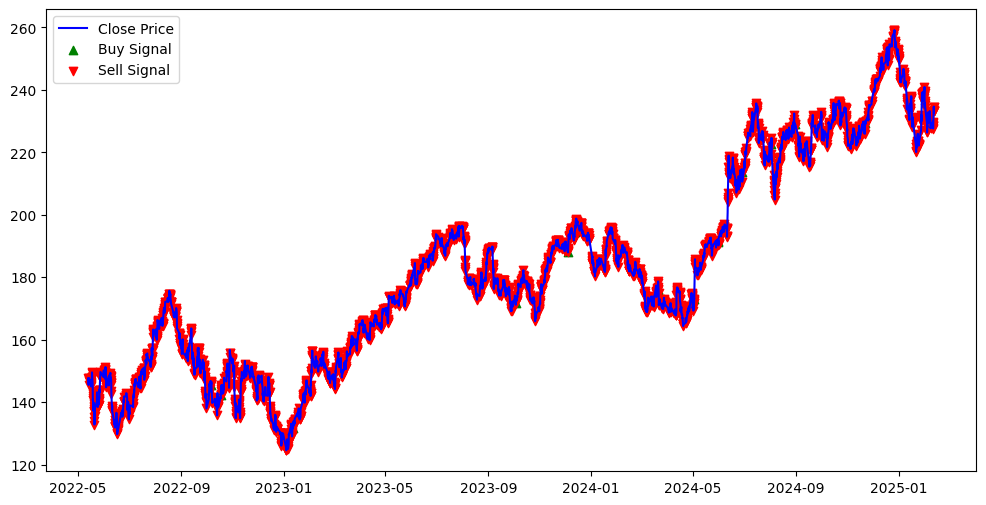

In [120]:
# Plot Buy/Sell Signals
plt.figure(figsize=(12,6))
plt.plot(df['Datetime'], df['Close'], label='Close Price', color='blue')
plt.scatter(df[df['Buy_Signal']]['Datetime'], df[df['Buy_Signal']]['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(df[df['Sell_Signal']]['Datetime'], df[df['Sell_Signal']]['Close'], marker='v', color='red', label='Sell Signal')
plt.legend()
plt.show()

In [121]:
# Initialize capital and trade log
capital = initial_balance
shares = 0
trade_log = []
STOP_LOSS_PERCENT = 0.90  # Stop-Loss at 10% drop
TAKE_PROFIT_PERCENT = 1.05  # Take-Profit at 10% gain
buy_price = None
last_trade_index = -5  # To prevent overtrading

for i in range(len(df)):
    price = df['Close'].iloc[i]
    if df['Buy_Signal'].iloc[i] and (i - last_trade_index) > 3 and capital >= price * 10:
        buy_price = price
        shares = capital // price
        capital -= shares * price
        trade_log.append(f"BUY at {price:.2f}")
        last_trade_index = i
    elif shares > 0:
        if price >= buy_price * TAKE_PROFIT_PERCENT:
            capital += shares * price
            shares = 0
            trade_log.append(f"SELL (Take-Profit) at {price:.2f}")
        elif price <= buy_price * STOP_LOSS_PERCENT:
            capital += shares * price
            shares = 0
            trade_log.append(f"SELL (Stop-Loss) at {price:.2f}")

if shares > 0:
    capital += shares * df['Close'].iloc[-1]
    trade_log.append(f"FINAL SELL at {df['Close'].iloc[-1]:.2f}")

profit_trades = sum([1 for i in range(1, len(trade_log), 2) if float(trade_log[i].split(" at ")[1]) > float(trade_log[i-1].split(" at ")[1])])
total_trades = len(trade_log) // 2
win_rate = (profit_trades / total_trades) * 100 if total_trades > 0 else 0

print(f"Final Portfolio Value: ${capital:.2f}")
print(f"Profit/Loss: ${capital - initial_balance:.2f}")
print(f"New Win Rate: {win_rate:.2f}%")
print(f"Trade Log: {trade_log}")

Final Portfolio Value: $13544.00
Profit/Loss: $3544.00
New Win Rate: 78.57%
Trade Log: ['BUY at 145.49', 'SELL (Take-Profit) at 154.60', 'BUY at 147.80', 'SELL (Stop-Loss) at 132.63', 'BUY at 131.68', 'SELL (Take-Profit) at 140.47', 'BUY at 164.65', 'SELL (Take-Profit) at 173.37', 'BUY at 193.73', 'SELL (Stop-Loss) at 174.27', 'BUY at 171.63', 'SELL (Take-Profit) at 181.72', 'BUY at 188.16', 'SELL (Take-Profit) at 197.87', 'BUY at 185.51', 'SELL (Take-Profit) at 195.05', 'BUY at 188.81', 'SELL (Stop-Loss) at 169.91', 'BUY at 172.52', 'SELL (Take-Profit) at 184.18', 'BUY at 191.45', 'SELL (Take-Profit) at 204.41', 'BUY at 213.84', 'SELL (Take-Profit) at 225.17', 'BUY at 222.83', 'SELL (Take-Profit) at 235.82', 'BUY at 229.29', 'SELL (Take-Profit) at 241.33']


In [122]:
print(f"Total Buy Signals: {df['Buy_Signal'].sum()}")
print(f"Total Sell Signals: {df['Sell_Signal'].sum()}")


Total Buy Signals: 29
Total Sell Signals: 4480
